Initial testing of STDP. This code contains a set of 4 presynaptic neurons (will be fed current from Mujoco model velocity feedback eventually) and two postsynaptic neurons. There will be a web of 8 connections that will need to be modified under STDP. The hopeful end goal is for two presynaptic neurons will learn connections with postsynaptic neuron A and two with postsynaptic neuron B.

For now, this code will hold the base template. Another test notebook will need to be made in order to test synaptic traces and the math model to change the synaptic connectivity. 

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt
from random import randint, Random

ISI code. Allows for the finding of frequency in the output spikes from the network.

In [3]:
# Takes spike data string, returns frequency of spikes
def getFreq(data, dt):
    loc = np.where(data == 1)[0]
    freq = []
    for i in range(len(loc)-1):
        freq.append(1 / ((loc[i+1] - loc[i]) * (dt * 0.001)))
    # The first element needs to be removed because this is inner spike, so more spikes than frequencies recorded
    loc = loc[1:] * dt
    return freq, loc

Random activation code. Will produce on and off periods for the four INs. Produces pairs of ons and offs for the two pairs of INs. They are in pairs because in the Mujoco environment, the feedback will come from two, virtually equal, sources. 

In [4]:
def randActivation(t, act_freq):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])
    
    act = 0b00

    for i in range(len(t)):
        if i % act_freq == 0:
            if act & 0b10:
                i_IN1[i-act_freq:i] += 1
            if act & 0b10:
                i_IN2[i-act_freq:i] += 1
            if act & 0b01:
                i_IN3[i-act_freq:i] += 1
            if act & 0b01:
                i_IN4[i-act_freq:i] += 1
            
            act = randint(0, 3)
    
    return i_IN1, i_IN2, i_IN3, i_IN4

def manualActivation(t, active_inputs):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    if active_inputs & 0b1000:
        i_IN1 += 1
    if active_inputs & 0b0100:
        i_IN2 += 1
    if active_inputs & 0b0010:
        i_IN3 += 1
    if active_inputs & 0b0001:
        i_IN4 += 1
    
    return i_IN1, i_IN2, i_IN3, i_IN4

def randActivation2(t, pair_freq, indi_freq):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    # Initilize at 0b00
    pair_act = 0b00
    indi_act = 0b00

    for i in range(len(t)):
        if pair_act & 0b01:
            if indi_act & 0b01:
                i_IN1[i] += 1
            if indi_act & 0b10:
                i_IN2[i] += 1

        if pair_act & 0b10:
            if indi_act & 0b01:
                i_IN3[i] += 1
            if indi_act & 0b10:
                i_IN4[i] += 1

        if i % pair_freq == 0:
            pair_act = randint(0, 3)
            
        if i % indi_freq == 0:
            indi_act = randint(0, 3)
    return i_IN1, i_IN2, i_IN3, i_IN4

def manualActivation2(t, split_ms):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    active = 1

    for i in range(len(t)):
        if active == 0:
            i_IN1[i] += 1 
            i_IN2[i] += 1

        if active == 1:
            i_IN3[i] += 1
            i_IN4[i] += 1
    
        if t[i] % split_ms == 0:
            active = not active

    return i_IN1, i_IN2, i_IN3, i_IN4


Random conductance connections generator. This will produce 8 random conductance values for the 8 connections between the innerneurons and the postsynaptic neurons.

In [5]:
def randConnectionCond(seed='AUGGGH', g_min=2.99, g_max=5.98):
    rng = Random(x=seed)
    '''
    For Conductances
    2.99 is a barely spikes the post when paired.
    g_max is for solo spiking. 
    '''
    g_min = int(g_min * 100) # Convert to int
    g_max = int(g_max * 100) # Convert to int

    # Generating two arrays for the 2 connection arrays needed for g_update
    g_POST1 = []
    g_POST2 = []

    for i in range(4):
        g_POST1.append(rng.randint(g_min, g_max) / 100) # Get rand int, convert back to float
        g_POST2.append(rng.randint(g_min, g_max) / 100)
    for i in range(2):
        g_POST1.append(0.0)
        g_POST2.append(0.0)
    
    return g_POST1, g_POST2

Plasticity window function. Send it a time difference, it will return your LTD or LTP value!

In [6]:
def weightUpdate(dt_array):
    A_pos = 0.1 # Max potentiation level
    A_neg = 0.25 # Max Depression value
    tou_pos = 10.0 # ms. Decay time constant for potentiation
    tou_neg = 11.0 # ms. Decay time constant for depression
    weight_change = []

    for dt in dt_array:
        if dt == None:
            weight_change.append(0.0)
        else:
            # If dt is positive, that means that the postsynaptic neuron spiked before the presynaptic. DEPRESSION
            if dt > 0:
                weight_change.append(-A_neg * np.exp(-dt / tou_neg))
            # If dt is negative, that means the presynaptic neuron spiked before the postsynaptic. POTENTIATION
            if dt <= 0:
                weight_change.append(A_pos * np.exp(dt / tou_pos))
    return weight_change

Building the base SNN

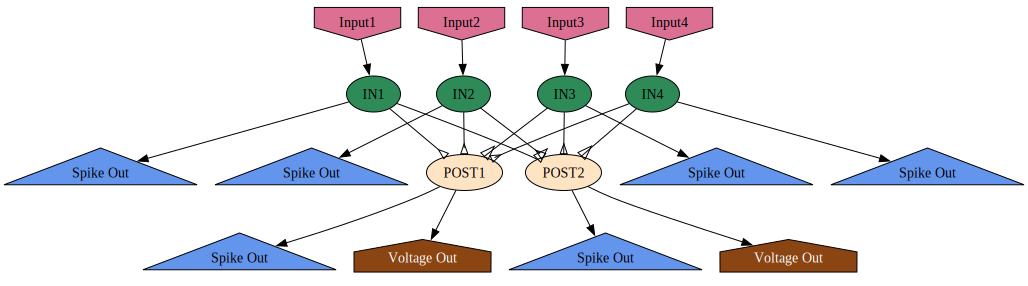

In [7]:
net = Network()

pre_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0,
)

post_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)

# Only one synapse needs to be defined. The inidividual connection values will be modified later.
stdp_synapse = SpikingSynapse(
    reversal_potential=2.0,
    max_conductance=5.0
)

# Is there a best order to add these in? I am not sure.
# Presynaptic Neurons
net.add_neuron(pre_neuron, name='IN1', color='seagreen')
net.add_neuron(pre_neuron, name='IN2', color='seagreen')
net.add_neuron(pre_neuron, name='IN3', color='seagreen')
net.add_neuron(pre_neuron, name='IN4', color='seagreen')
# Postsynaptic Neurons
net.add_neuron(post_neuron, name='POST1', color='bisque')
net.add_neuron(post_neuron, name='POST2', color='bisque')
# Order of addition of neurons
neuron_list = ['IN1', 'IN2', 'IN3', 'IN4', 'POST1', 'POST2']
# Connections
net.add_connection(stdp_synapse, source='IN1', destination='POST1')
net.add_connection(stdp_synapse, source='IN1', destination='POST2')

net.add_connection(stdp_synapse, source='IN2', destination='POST1')
net.add_connection(stdp_synapse, source='IN2', destination='POST2')

net.add_connection(stdp_synapse, source='IN3', destination='POST1')
net.add_connection(stdp_synapse, source='IN3', destination='POST2')

net.add_connection(stdp_synapse, source='IN4', destination='POST1')
net.add_connection(stdp_synapse, source='IN4', destination='POST2')
# Inputs
net.add_input(dest='IN1', name='Input1', color='palevioletred')
net.add_input(dest='IN2', name='Input2', color='palevioletred')
net.add_input(dest='IN3', name='Input3', color='palevioletred')
net.add_input(dest='IN4', name='Input4', color='palevioletred')
# Outputs
# POST Outputs
net.add_output(source='POST1', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='POST1', name='Voltage Out', spiking=False, color='saddlebrown')
net.add_output(source='POST2', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='POST2', name='Voltage Out', spiking=False, color='saddlebrown')
# IN Outputs
net.add_output(source='IN1', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='IN2', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='IN3', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='IN4', name='Spike Out', spiking=True, color='cornflowerblue')
# Order of addition of outputs for plotting reference
output_list = ['POST1 Spike', 'POST1 Voltage', 'POST2 Spike', 'POST2 Voltage', 'IN1 Spike', 'IN2 Spike', 'IN3 Spike', 'IN4 Spike']

# Render the network
render(net)

In [8]:
from sns_toolbox.color_utilities import SETOFVALIDCOLORS
print(SETOFVALIDCOLORS)

{'antiquewhite', 'deepskyblue', 'slategrey', 'chocolate', 'aquamarine', 'azure', 'snow', 'lavender', 'silver', 'moccasin', 'floralwhite', 'cornsilk', 'indigo', 'darkkhaki', 'mediumseagreen', 'darkslateblue', 'ivory', 'slategray', 'mediumturquoise', 'beige', 'seagreen', 'rosybrown', 'mediumvioletred', 'steelblue', 'darkolivegreen', 'indianred', 'lightpink', 'mediumpurple', 'mediumblue', 'lightyellow', 'lightgoldenrodyellow', 'cadetblue', 'blue', 'tomato', 'navy', 'darksalmon', 'lightgray', 'navajowhite', 'lavenderblush', 'royalblue', 'magenta', 'linen', 'maroon', 'limegreen', 'slateblue', 'mediumorchid', 'honeydew', 'thistle', 'deeppink', 'goldenrod', 'saddlebrown', 'lime', 'lightsalmon', 'wheat', 'gold', 'lightgrey', 'firebrick', 'darkcyan', 'gainsboro', 'plum', 'lightblue', 'green', 'springgreen', 'olivedrab', 'red', 'powderblue', 'blueviolet', 'hotpink', 'darkgoldenrod', 'darkgreen', 'lightgreen', 'fuchsia', 'lightsteelblue', 'paleturquoise', 'greenyellow', 'lightskyblue', 'lightcora

Compiling the model.

In [9]:
dt = 0.1 # ms
tmax = 10000 # ms
t = np.arange(0, tmax, dt)
model = net.compile(dt=dt, backend='numpy', debug=False)

Looking at the connection matrix to see what it looks like.

In [10]:
print(neuron_list)
print(model.__dict__.get('g_max_spike'))

['IN1', 'IN2', 'IN3', 'IN4', 'POST1', 'POST2']
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 0. 0.]
 [5. 5. 5. 5. 0. 0.]]


Super basic addressing of the two postsynaptic neuron connections.

In [11]:
g_update = np.zeros([net.get_num_neurons(), net.get_num_neurons()]) + model.__dict__.get('g_max_spike')
g_POST1 = np.zeros([1, net.get_num_neurons()])
g_POST2 = np.zeros([1, net.get_num_neurons()])

'''
For Conductances
2.99 is a barely spikes the post when paired.
5.98 is for solo spiking. 
'''
g_max = 4.5
g_floor = 0.0

# Assigning values to connectivity of synapses
g_POST1, g_POST2 = randConnectionCond(seed='Jack Is', g_max=g_max, g_min=0.50)

# Manual input values if needed
g_POST1 = [4.0, 2.2, 4.5, 1.0, 0, 0]
g_POST2 = [0.1, 4.1, 2.5, 4.5, 0, 0]

# Pulling out inidividual conductances in order to modify later on
IN1_to_POST1 = g_POST1[0]
IN2_to_POST1 = g_POST1[1]
IN3_to_POST1 = g_POST1[2]
IN4_to_POST1 = g_POST1[3]

IN1_to_POST2 = g_POST2[0]
IN2_to_POST2 = g_POST2[1]
IN3_to_POST2 = g_POST2[2]
IN4_to_POST2 = g_POST2[3]

# Placing synapse values in the g_update to send to backend
g_update[-2] = g_POST1
g_update[-1] = g_POST2

# Printing post modification values
print(g_update)
g_start = np.copy(g_update)

[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]
 [4.  2.2 4.5 1.  0.  0. ]
 [0.1 4.1 2.5 4.5 0.  0. ]]


Initilizing Vales

In [12]:
# Setting baseline inputs
inputs = np.zeros([len(t), net.get_num_inputs()])

# Initilize spike condition
IN1_spike_last = 0
IN2_spike_last = 0
IN3_spike_last = 0
IN4_spike_last = 0
POST1_spike_last = 0
POST2_spike_last = 0
update_g = 0

# Set up arrays for plotting changing conductances
plot_IN1_t = [0.0]
plot_IN2_t = [0.0]
plot_IN3_t = [0.0]
plot_IN4_t = [0.0]
plot_IN1_POST1 = [IN1_to_POST1]
plot_IN2_POST1 = [IN2_to_POST1]
plot_IN3_POST1 = [IN3_to_POST1]
plot_IN4_POST1 = [IN4_to_POST1]
plot_IN1_POST2 = [IN1_to_POST2]
plot_IN2_POST2 = [IN2_to_POST2]
plot_IN3_POST2 = [IN3_to_POST2]
plot_IN4_POST2 = [IN4_to_POST2]

Simulation Running

In [13]:
''' Generating inputs (randomized or manual)'''
# i_IN1, i_IN2, i_IN3, i_IN4 = randActivation(t, 1000) # Time step is 0.01 ms with max time of 50 ms. So a frequency of 1000 will be every 10.0 ms, or 5 changes. 
# i_IN1, i_IN2, i_IN3, i_IN4 = randActivation2(t, 5000, 5000) # first number is # of time steps to switch pair (IN1&IN2 or IN3&IN4), second # is # of time steps to activate one or other in pair
# i_IN1, i_IN2, i_IN3, i_IN4 = manualActivation(t, 0b1101) # IN1, IN2, IN3, IN4 as 0b0000 L to R
i_IN1, i_IN2, i_IN3, i_IN4 = manualActivation2(t, 100)

''' Optional offset so that inputs aren't perfectly synced '''
# i_IN1[0:50] = 0
# i_IN3[0:250] = 0
# i_IN4[0:25] = 0

''' All above added. Inputs are given from the MN SSN, no longer need to manually assign '''

# Assigning Inputs to single variable for snn model
inputs[:,0] = i_IN1 * 1.04 # IN1
inputs[:,1] = i_IN2 * 1.04 # IN2
inputs[:,2] = i_IN3 * 1.04 # IN3
inputs[:,3] = i_IN4 * 1.04 # IN4

# Creating open matrix for the outputs
data = np.zeros([len(t), net.get_num_outputs_actual()])

for i in range(len(t)):
    data[i,:] = model(inputs[i,:], current_time=t[i], dt=dt, g_update=g_update)
    
    ''' Print Debugging Code for POST spike timings and stuff
    # Checking POST1 Spikes
    if data[i,0] == 1:
        print('POST1 Spiked at ' + str(model.__dict__.get('spike_time')[4]) + 'ms')
        print('Spike timings of IN1, IN2, IN3, IN4, POST1, POST2')
        print(model.__dict__.get('spike_time'))
        print('Spike time difference between POST1 and (IN1, IN2, IN3, IN4)')
        print(model.__dict__.get('POST1_spike_diff'))
        print('')
    # Checking POST2 Spikes
    if data[i,2] == 1:
        print('POST2 Spiked at ' + str(model.__dict__.get('spike_time')[5]) + 'ms')
        print('Spike timings of IN1, IN2, IN3, IN4, POST1, POST2')
        print(model.__dict__.get('spike_time'))
        print('Spike time difference between POST1 and (IN1, IN2, IN3, IN4)')
        print(model.__dict__.get('POST2_spike_diff'))
        print('')
    '''

    ''' STDP Modification Code '''
    # Update conductance values from the LAST loop's spiking condition
    ''' LTD '''
    if IN1_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(model.__dict__.get('IN1_spike_diff'))

        # Update conductance value to specific connections
        IN1_to_POST1 = IN1_to_POST1 + ltd1
        IN1_to_POST2 = IN1_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN1_to_POST1 < g_floor:
            IN1_to_POST1 = g_floor
        if IN1_to_POST2 < g_floor:
            IN1_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN1_t.append(t[i])
        plot_IN1_POST1.append(IN1_to_POST1)
        plot_IN1_POST2.append(IN1_to_POST2)

        # Reset spiking condition
        IN1_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if IN2_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(model.__dict__.get('IN2_spike_diff'))

        # Update conductance value to specific connections
        IN2_to_POST1 = IN2_to_POST1 + ltd1
        IN2_to_POST2 = IN2_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN2_to_POST1 < g_floor:
            IN2_to_POST1 = g_floor
        if IN2_to_POST2 < g_floor:
            IN2_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN2_t.append(t[i])
        plot_IN2_POST1.append(IN2_to_POST1)
        plot_IN2_POST2.append(IN2_to_POST2)

        # Reset spiking condition
        IN2_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if IN3_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(model.__dict__.get('IN3_spike_diff'))

        # Update conductance value to specific connections
        IN3_to_POST1 = IN3_to_POST1 + ltd1
        IN3_to_POST2 = IN3_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN3_to_POST1 < g_floor:
            IN3_to_POST1 = g_floor
        if IN3_to_POST2 < g_floor:
            IN3_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN3_t.append(t[i])
        plot_IN3_POST1.append(IN3_to_POST1)
        plot_IN3_POST2.append(IN3_to_POST2)

        # Reset spiking condition
        IN3_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if IN4_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(model.__dict__.get('IN4_spike_diff'))

        # Update conductance value to specific connections
        IN4_to_POST1 = IN4_to_POST1 + ltd1
        IN4_to_POST2 = IN4_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN4_to_POST1 < g_floor:
            IN4_to_POST1 = g_floor
        if IN4_to_POST2 < g_floor:
            IN4_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN4_t.append(t[i])
        plot_IN4_POST1.append(IN4_to_POST1)
        plot_IN4_POST2.append(IN4_to_POST2)

        # Reset spiking condition
        IN4_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    ''' LTP '''
    if POST1_spike_last == -1:
        # Use time POST1 spiked after IN1, IN2, IN3, IN4 to find weight updates
        ltp1, ltp2, ltp3, ltp4 = weightUpdate(model.__dict__.get('POST1_spike_diff'))

        # Apply weight updates
        IN1_to_POST1 = IN1_to_POST1 + ltp1
        IN2_to_POST1 = IN2_to_POST1 + ltp2
        IN3_to_POST1 = IN3_to_POST1 + ltp3
        IN4_to_POST1 = IN4_to_POST1 + ltp4

        # Ensuring none of the values have crossed the max value
        if IN1_to_POST1 > g_max:
            IN1_to_POST1 = g_max
        if IN2_to_POST1 > g_max:
            IN2_to_POST1 = g_max
        if IN3_to_POST1 > g_max:
            IN3_to_POST1 = g_max
        if IN4_to_POST1 > g_max:
            IN4_to_POST1 = g_max

        # Reset spiking condition
        POST1_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if POST2_spike_last == -1:
        # Use time POST2 spiked after IN1, IN2, IN3, IN4 to find weight updates
        ltp1, ltp2, ltp3, ltp4 = weightUpdate(model.__dict__.get('POST2_spike_diff'))

        # Apply weight updates
        IN1_to_POST2 = IN1_to_POST2 + ltp1
        IN2_to_POST2 = IN2_to_POST2 + ltp2
        IN3_to_POST2 = IN3_to_POST2 + ltp3
        IN4_to_POST2 = IN4_to_POST2 + ltp4

        # Ensuring none of the values have crossed the max value
        if IN1_to_POST2 > g_max:
            IN1_to_POST2 = g_max
        if IN2_to_POST2 > g_max:
            IN2_to_POST2 = g_max
        if IN3_to_POST2 > g_max:
            IN3_to_POST2 = g_max
        if IN4_to_POST2 > g_max:
            IN4_to_POST2 = g_max

        # Reset spiking condition
        POST2_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    # Update conductance array
    if update_g == 1:
        # Update conductance values
        g_POST1 = [IN1_to_POST1, IN2_to_POST1, IN3_to_POST1, IN4_to_POST1, 0, 0]
        g_POST2 = [IN1_to_POST2, IN2_to_POST2, IN3_to_POST2, IN4_to_POST2, 0, 0]
        # Placing synapse values in the g_update to send to backend
        g_update[-2] = g_POST1
        g_update[-1] = g_POST2
        # Reset update command
        update_g = 0

    # Check this loops spiking conditions
    if sum(model.__dict__.get('spikes')) != 0:
        spikes = model.__dict__.get('spikes')
        IN1_spike_last = spikes[0]
        IN2_spike_last = spikes[1]
        IN3_spike_last = spikes[2]
        IN4_spike_last = spikes[3]
        POST1_spike_last = spikes[4]
        POST2_spike_last = spikes[5]

# Place data in correct format for plotting
data = data.transpose()

Plotting the data

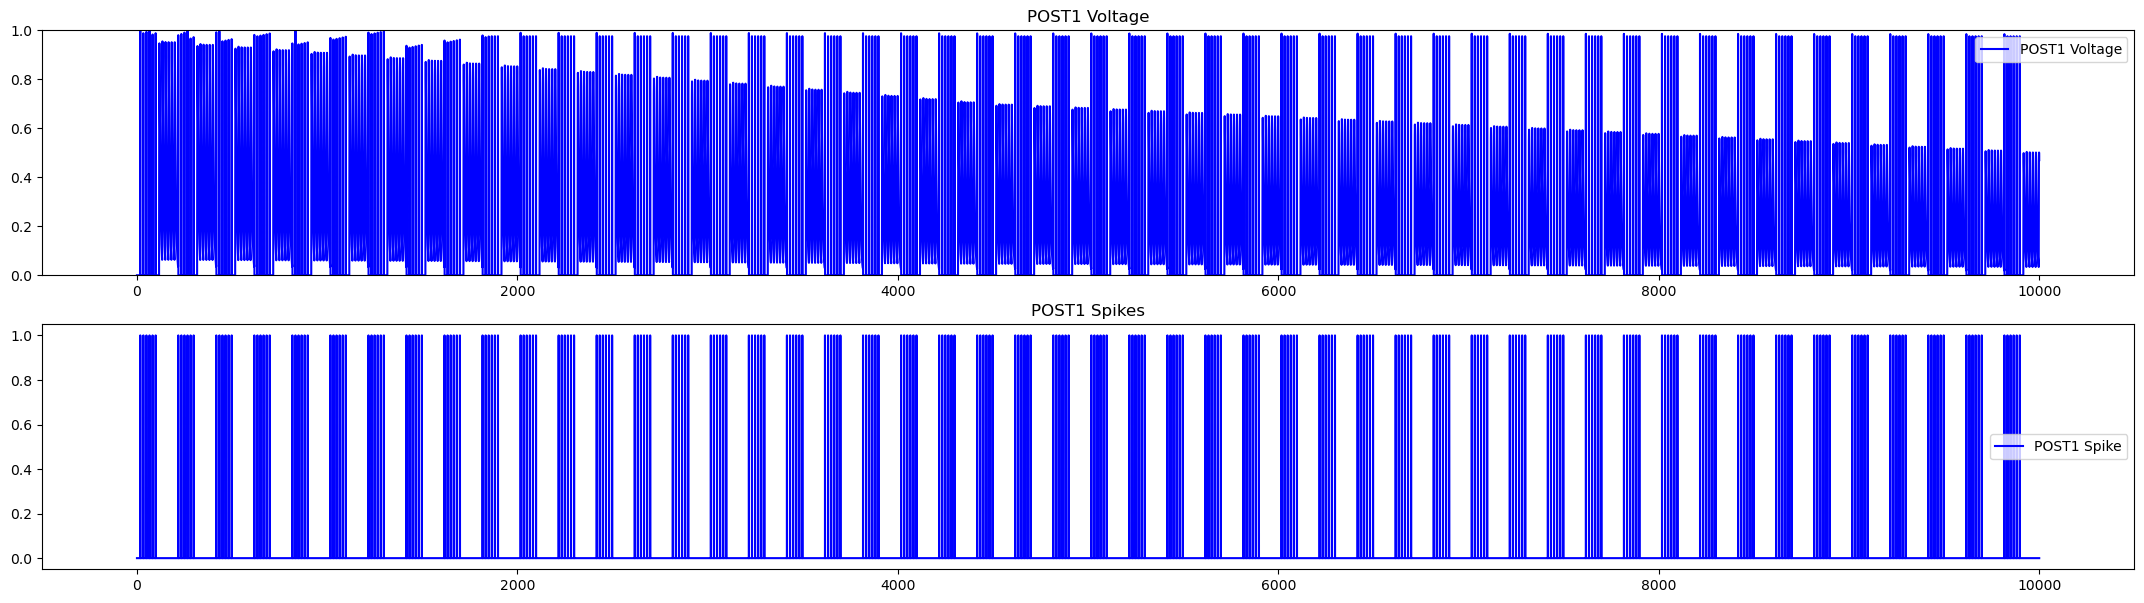

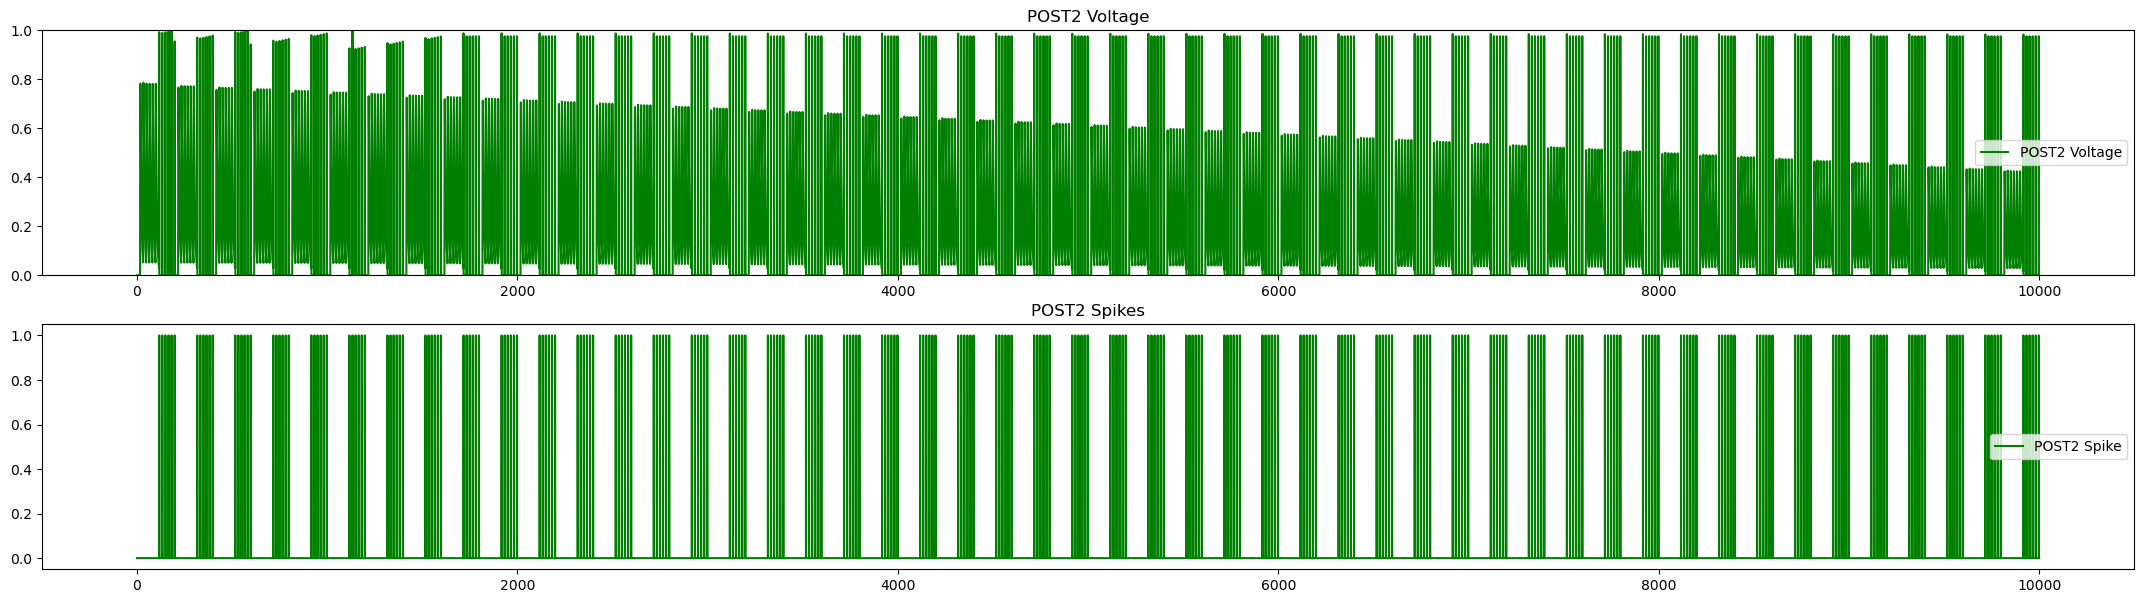

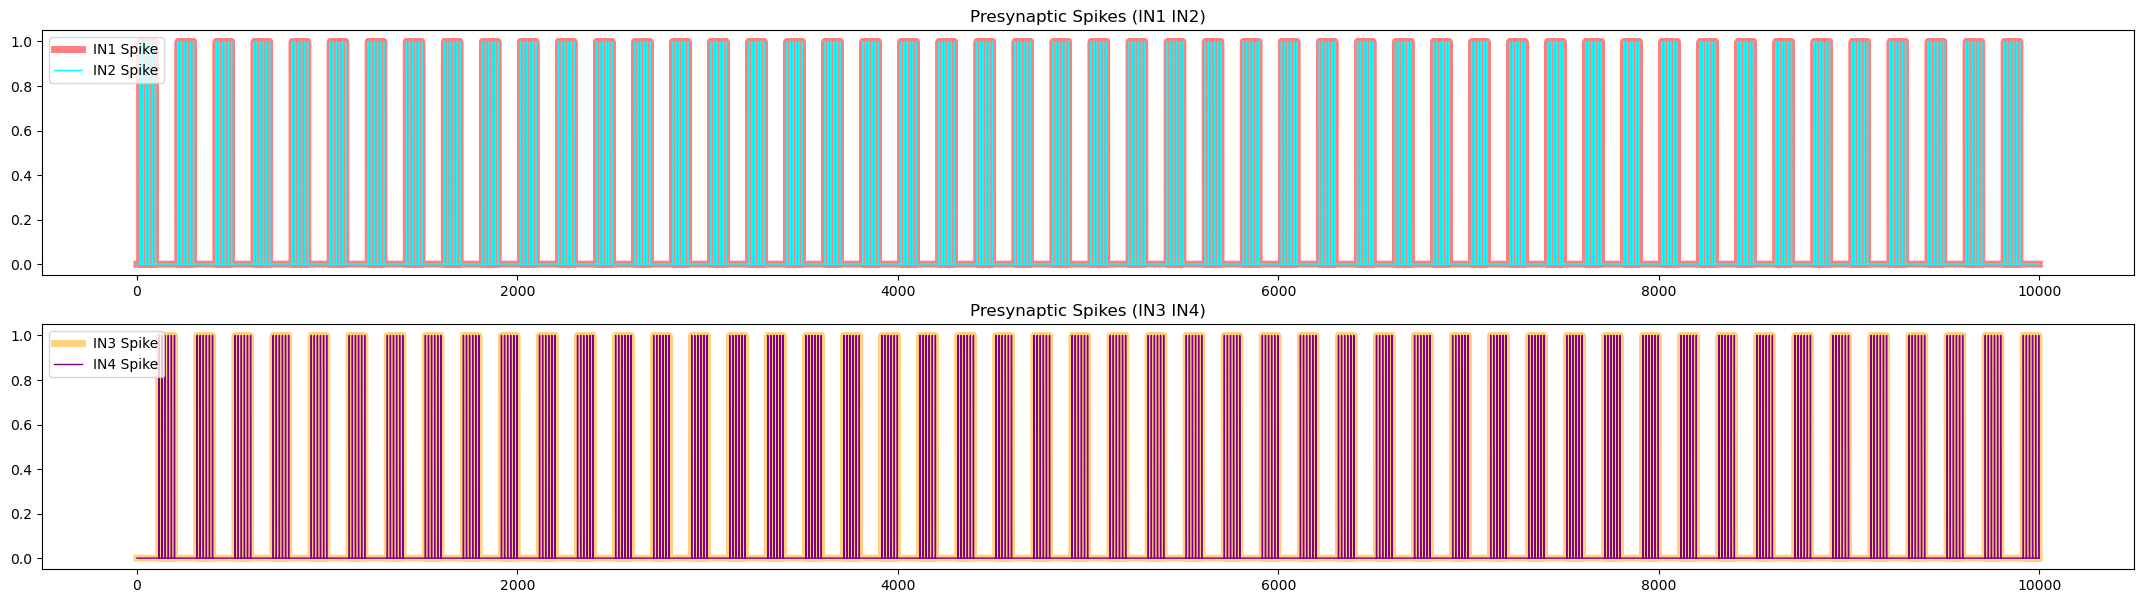

In [14]:
# Plot for POST1
plt.figure(figsize=[27, 7])
plt.subplot(2, 1, 1)
plt.plot(t, data[1,:], label=output_list[1], color='blue')
plt.legend()
plt.ylim(0, 1)
plt.title('POST1 Voltage')
plt.subplot(2, 1, 2)
plt.plot(t, data[0,:], label=output_list[0], color='blue')
plt.legend()
plt.title('POST1 Spikes')
plt.show()

# Plot for POST2
plt.figure(figsize=[27, 7])
plt.subplot(2, 1, 1)
plt.plot(t, data[3,:], label=output_list[3], color='green')
plt.legend()
plt.ylim(0, 1)
plt.title('POST2 Voltage')
plt.subplot(2, 1, 2)
plt.plot(t, data[2,:], label=output_list[2], color='green')
plt.legend()
plt.title('POST2 Spikes')
plt.show()

# Plot for presynaptic spikes
plt.figure(figsize=[27,7])
plt.subplot(2, 1, 1)
plt.plot(t, data[4,:], '-', alpha=0.5, color='red', linewidth=5, label=output_list[4])
plt.plot(t, data[5,:], '-', alpha=1.0, color='cyan', linewidth=1, label=output_list[5])
plt.title('Presynaptic Spikes (IN1 IN2)')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(t, data[6,:], '-', alpha=0.5, color='orange', linewidth=5, label=output_list[6])
plt.plot(t, data[7,:], '-', alpha=1.0, color='purple', linewidth=1, label=output_list[7])
plt.title('Presynaptic Spikes (IN3 IN4)')
plt.legend(loc='upper left')
plt.show()

In [15]:
print(model.__dict__.get('IN1_spike_diff'))

[np.float64(15.600000000000364), np.float64(99.39999999999964)]


Spiking frequency of Post1 and Post2

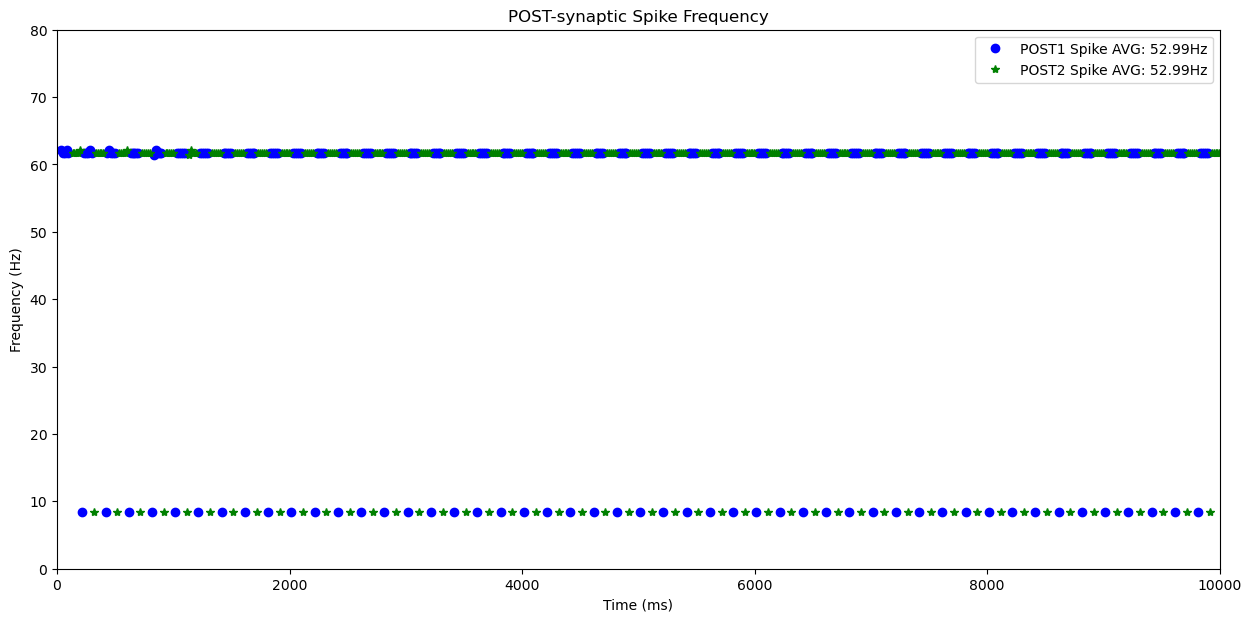

In [16]:
POST1_frequency, POST1_loc = getFreq(data=data[0,:], dt=dt)
POST2_frequency, POST2_loc = getFreq(data=data[2,:], dt=dt)

if len(POST1_frequency) > 1:
    POST1_avg = np.round(np.average(POST1_frequency), 2)
else:
    POST1_avg = np.zeros(1)
if len(POST2_frequency) > 1:
    POST2_avg = np.round(np.average(POST2_frequency), 2)
else:
    POST2_avg = np.zeros(1)

freq_label = ['POST1 Spike AVG: ' + str(POST1_avg) + 'Hz', 'POST2 Spike AVG: ' + str(POST2_avg)+ 'Hz']

plt.figure(figsize=[15, 7])
plt.plot(POST1_loc, POST1_frequency, 'o', color='blue', label=freq_label[0])
plt.plot(POST2_loc, POST2_frequency, '*', color='green', label=freq_label[1])
plt.legend()
plt.title('POST-synaptic Spike Frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.ylim(0, 80)
plt.xlim(0, tmax)
plt.show()

Plot of the change in synaptic conductance weight over the whole of the simulation.

Text(0, 0.5, 'Conductance (uS)')

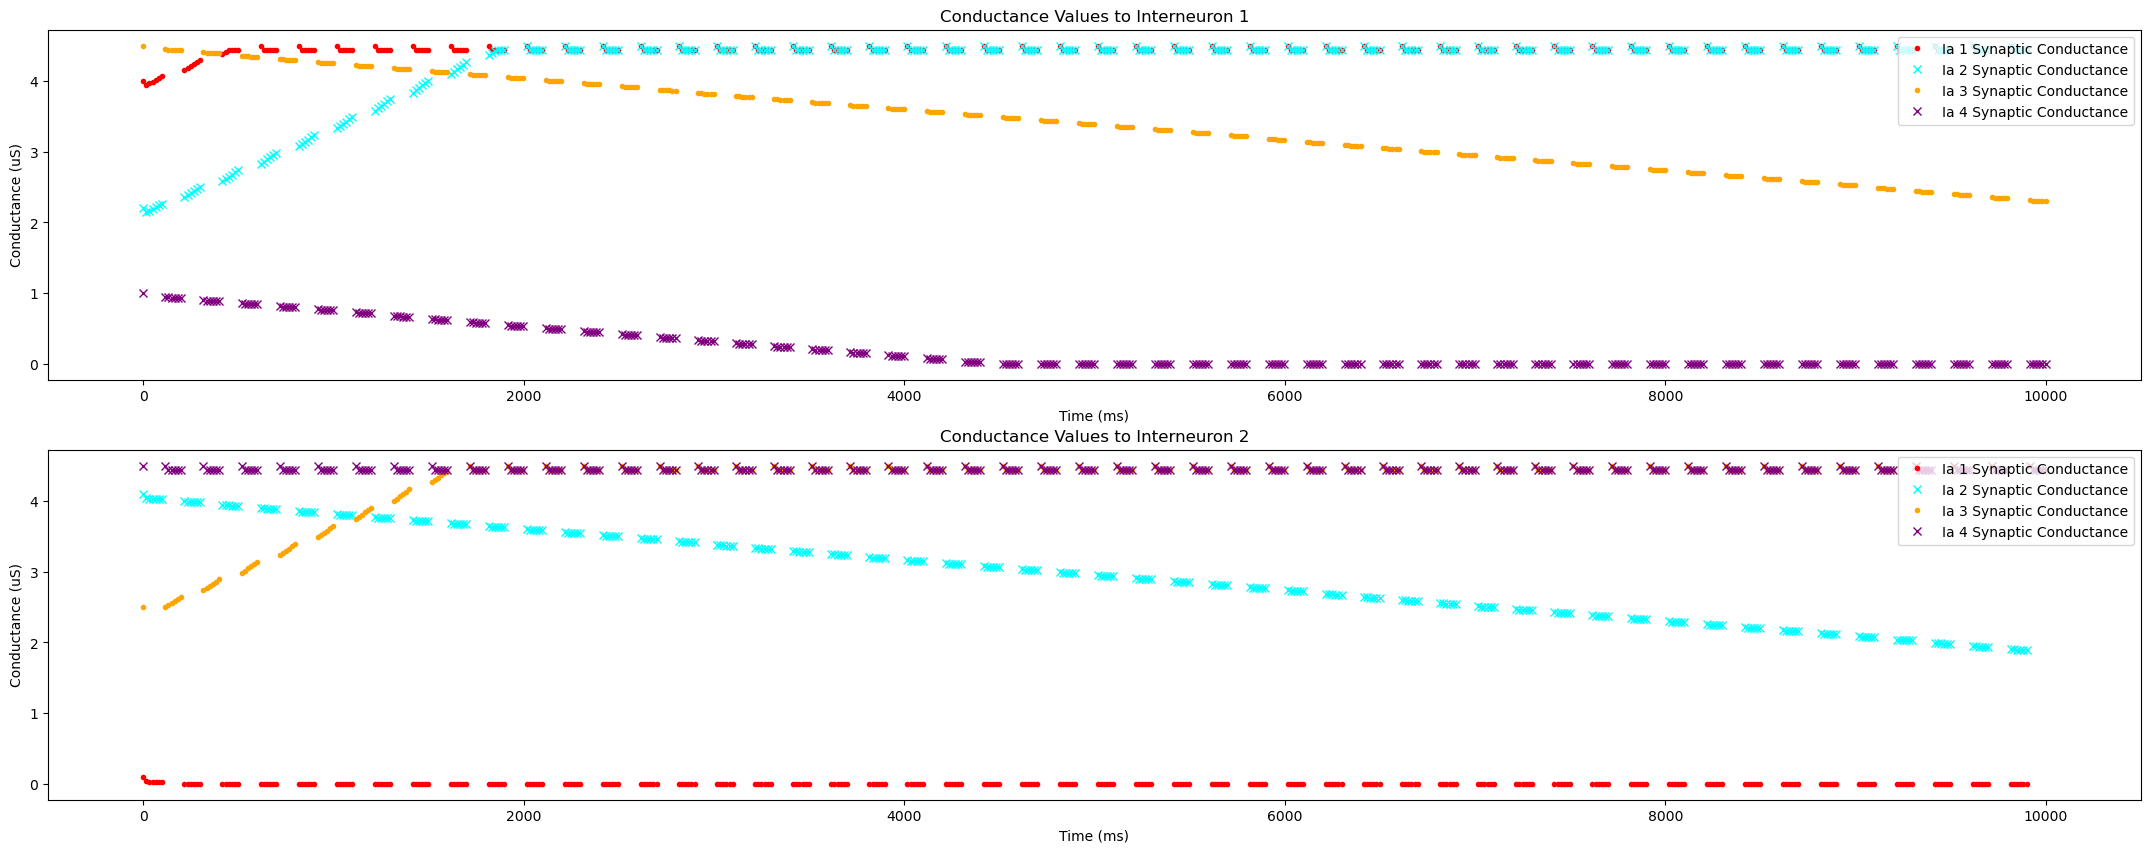

In [19]:
plt.figure(figsize=[27, 10])
plt.subplot(2, 1, 1)
plt.title(label='Conductance Values to Interneuron 1')
plt.plot(plot_IN1_t, plot_IN1_POST1, '.', label='Ia 1 Synaptic Conductance', color='red')
plt.plot(plot_IN2_t, plot_IN2_POST1, 'x', label='Ia 2 Synaptic Conductance', color='cyan')
plt.plot(plot_IN3_t, plot_IN3_POST1, '.', label='Ia 3 Synaptic Conductance', color='orange')
plt.plot(plot_IN4_t, plot_IN4_POST1, 'x', label='Ia 4 Synaptic Conductance', color='purple')
plt.legend(loc='upper right')
plt.xlabel(xlabel='Time (ms)')
plt.ylabel(ylabel='Conductance (uS)')
# plt.ylim([0, 6])

plt.subplot(2, 1, 2)
plt.title(label='Conductance Values to Interneuron 2')
plt.plot(plot_IN1_t, plot_IN1_POST2, '.', label='Ia 1 Synaptic Conductance', color='red')
plt.plot(plot_IN2_t, plot_IN2_POST2, 'x', label='Ia 2 Synaptic Conductance', color='cyan')
plt.plot(plot_IN3_t, plot_IN3_POST2, '.', label='Ia 3 Synaptic Conductance', color='orange')
plt.plot(plot_IN4_t, plot_IN4_POST2, 'x', label='Ia 4 Synaptic Conductance', color='purple')
plt.legend(loc='upper right')
plt.xlabel(xlabel='Time (ms)')
plt.ylabel(ylabel='Conductance (uS)')
# plt.ylim([0, 6])

In [18]:
# print(g_update)
# print(g_start)

print('initial synaptic connectivity')
print(g_start[4][0:4])
print(g_start[5][0:4])

print('total change in synaptic connectivity')
print(g_update[4][0:4] - g_start[4][0:4])
print(g_update[5][0:4] - g_start[5][0:4])

print('final synaptic connectivity')
print(g_update[4][0:4])
print(g_update[5][0:4])

initial synaptic connectivity
[4.  2.2 4.5 1. ]
[0.1 4.1 2.5 4.5]
total change in synaptic connectivity
[ 0.5         2.3        -2.19449377 -1.        ]
[-0.08243988 -2.18539113  2.          0.        ]
final synaptic connectivity
[4.5        4.5        2.30550623 0.        ]
[0.01756012 1.91460887 4.5        4.5       ]
